In [1]:
import os

import numpy
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import scipy
import seaborn
import tensorflow

import tensorflow.keras
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
pandas.options.display.max_columns = None
pandas.options.display.max_colwidth = None

In [3]:
# Helper functions
def one_hot_encode(sequences, max_seq_len=None, mask_val=-1, padding='left'):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}

    # Automatically use max length if not specified
    if max_seq_len is None:
        max_seq_len = numpy.max([len(s) for s in sequences])
    
    # Creat empty matrix
    one_hot_seqs = numpy.ones([len(sequences), max_seq_len, 4])*mask_val
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences):
        # Truncate
        if padding=='left':
            seq = seq[:max_seq_len]
        elif padding=='right':
            seq = seq[-max_seq_len:]
        else:
            raise ValueError(f'padding {padding} not recognized')
        # Convert to array
        seq = seq.lower()
        one_hot_seq = numpy.array([nuc_d[x] for x in seq])
        # Append to matrix
        if padding=='left':
            one_hot_seqs[i, :len(seq), :] = one_hot_seq
        elif padding=='right':
            one_hot_seqs[i, -len(seq):, :] = one_hot_seq
        else:
            raise ValueError(f'padding {padding} not recognized')
            
    return one_hot_seqs

# Load data

In [4]:
# Dataframes to accumulate all data
data_train = pandas.DataFrame()
data_val = pandas.DataFrame()
data_test = pandas.DataFrame()

In [5]:
datasets = [
    {
        'cell_line': 'HEK293T',
        'replicate': 1,
        'path': '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total_reads'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total_reads': 'Reads'},
    },
    {
        'cell_line': 'HEK293T',
        'replicate': 2,
        'path': '../polysome_profiling_sample2019/GSM3130436_egfp_unmod_2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 1,
        'path': '../polysome_profiling_data/defined_end_tcell_r1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 2,
        'path': '../polysome_profiling_data/defined_end_tcell_r2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'HepG2',
        'replicate': 1,
        'path': '../polysome_profiling_data/defined_end_hepg2_r1.csv.gz',
        'cols_to_load': ['UTR', 'rl', 'total'],
        'cols_to_rename': {'rl': 'MRL', 'total': 'Reads'},
    }
]

In [6]:
# Load, preprocess, and compile data
multicol = pandas.MultiIndex(
    levels=[[], [], []],
    codes=[[], [], []],
    names=['Measurement', 'Cell type', 'Replicate'],
)
data_table_combined = pandas.DataFrame(columns=multicol)

for dataset in datasets:
    # Load only desired columns, rename
    data_table = pandas.read_csv(dataset['path'], usecols=dataset['cols_to_load'])
    data_table.rename(columns=dataset['cols_to_rename'], inplace=True)
    data_table['UTR'] = data_table['UTR'].str[:50]
    data_table = data_table.set_index('UTR')
    # Eliminate the large number of sequences with one read
    data_table = data_table[data_table['Reads'] > 1]

    # Convert to multiindex
    data_table = data_table[['Reads', 'MRL']]
    multicol = pandas.MultiIndex.from_product(
        [['Reads', 'MRL'], [dataset['cell_line']], [dataset['replicate']]],
        names=['Measurement', 'Cell type', 'Replicate'],
    )
    data_table.columns = multicol

    # Store
    data_table_combined = data_table_combined.merge(data_table, how='outer', left_index=True, right_index=True)
    
    print("{:,} sequences loaded for cell line {} rep {}.".format(len(data_table), dataset['cell_line'], dataset['replicate']))

# Set NaN reads to zero
data_table_combined['Reads'] = data_table_combined['Reads'].fillna(0)
# Set NaN MRLs to -1
data_table_combined['MRL'] = data_table_combined['MRL'].fillna(-1)

# Sort by minimum number of reads
data_table_combined = data_table_combined.loc[
    data_table_combined['Reads'].min(axis=1).sort_values(ascending=False).index
]

# Add uATG
data_table_combined['uATG'] = False
data_table_combined.loc[data_table_combined.index.str.contains('ATG'), 'uATG'] = True
# data_table_combined.loc[~data_table_combined.index.str.contains('ATG'), 'uATG'] = False

display(data_table_combined)

326,033 sequences loaded for cell line HEK293T rep 1.
351,575 sequences loaded for cell line HEK293T rep 2.
349,633 sequences loaded for cell line T cells rep 1.
352,724 sequences loaded for cell line T cells rep 2.
789,594 sequences loaded for cell line HepG2 rep 1.


Measurement,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,Reads,MRL,uATG
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,
Replicate,1,1,2,2,1,1,2,2,1,1,
UTR,,,,,,,,,,,
CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,12126.0,3.039939,2633.0,2.688568,4900.0,1.995057,3865.0,2.583809,2955.0,1.846297,True
CTAATCGCCCATTTAGGCGCGGATCATCCTATTCAGCCAGTGGATAAGCG,8838.0,7.800806,2802.0,6.458601,2846.0,6.121909,2570.0,6.745352,6627.0,4.595709,False
GCGCATCACCACGGCCTCAGAGCAGCCCGCCTAGTACTCTGCCGCTTGTC,6177.0,7.606182,2457.0,6.499796,3057.0,5.536605,2711.0,5.934799,4435.0,4.353461,False
CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,10368.0,3.895109,2138.0,3.855005,2598.0,3.531917,2395.0,3.925099,2639.0,2.166412,True
CCCCGAGGCTTGTGAGGAGTAAAACCCAAGAGAGGTAAAGTGCCACACAA,5503.0,4.654325,1954.0,3.646878,3610.0,3.057525,2500.0,3.251278,2091.0,2.606412,False
...,...,...,...,...,...,...,...,...,...,...,...
CCGGAAGGCCGTTTACCGTACAAACGCGCGGTAAAAAAGCGCACTGCGCA,0.0,-1.000000,0.0,-1.000000,0.0,-1.000000,0.0,-1.000000,4.0,4.000000,False


In [ ]:
# Extract cell lines
cell_lines_nonunique = [d['cell_line'] for d in datasets]
cell_lines = list(dict.fromkeys(cell_lines_nonunique))
cell_lines_reps = [cell_lines_nonunique.count(c) for c in cell_lines]
# Columns for the data table
cell_lines_reps_cols = [(d['cell_line'], d['replicate']) for d in datasets]

print(cell_lines)
print(cell_lines_reps)
print(cell_lines_reps_cols)

['HEK293T', 'T cells', 'HepG2']
[2, 2, 1]
[('HEK293T', 1), ('HEK293T', 2), ('T cells', 1), ('T cells', 2), ('HepG2', 1)]


In [ ]:
# Split into training, validation, testing
data_test = data_table_combined.iloc[:20000]
data_val = data_table_combined.iloc[20000:30000]
data_train = data_table_combined.iloc[30000:]

In [ ]:
data_train['Reads'].loc[:, cell_lines_reps_cols]

Cell type                                          HEK293T        T cells  \
Replicate                                                1      2       1   
UTR                                                                         
GGAAAAGGACTCTTGCTAAAGCAGAACCACAAGAGAAACGACCCTTCGAC  1706.0  476.0   526.0   
CAACAGAAAACACACAGTGGCCTGTAAACGTAAACGGATAGTGCGACGAA  2260.0  476.0   543.0   
GCTCTAACACGACTGGTCTAAAATCTCCATGAAACAGAGGAATCAATCCA  2621.0  476.0   715.0   
CCCCATCGACCATTCAAGGTCCAGAACATCAGAATCCGACGCGTGCCTCC  1597.0  476.0   571.0   
GTAAGTGGCGAGCCGGACCCATGAGGGCCGATTGCCTATAAGCCGATCTT  1924.0  493.0   596.0   
...                                                    ...    ...     ...   
CCGGAAGGCCGTTTACCGTACAAACGCGCGGTAAAAAAGCGCACTGCGCA     0.0    0.0     0.0   
CCGGAAGGCGAAACGGTAACTACGAACGGGCGGACCTAGCCACGGTTTAT     0.0    0.0     0.0   
CCGGAAGGCGAGGCATATAAAATGGCGAACACGCATCCTACCCGCGATAT     0.0    0.0     0.0   
CCGGAAGGCGAGTCAGGCTATAGATATGTAATTACCGCCAGTTTACCAAT     0.0    0.0     0.0   
TTTTTTTTTTGAGTTAGAAAACATTGGATCGGTCCGGGTCAAAGGGGAGA     0.0    0.0     0.0   

Cell type                                                    HepG2  
Replicate                                                2       1  
UTR                                                                 
GGAAAAGGACTCTTGCTAAAGCAGAACCACAAGAGAAACGACCCTTCGAC   577.0  1203.0  
CAACAGAAAACACACAGTGGCCTGTAAACGTAAACGGATAGTGCGACGAA   975.0   707.0  
GCTCTAACACGACTGGTCTAAAATCTCCATGAAACAGAGGAATCAATCCA  1060.0   646.0  
CCCCATCGACCATTCAAGGTCCAGAACATCAGAATCCGACGCGTGCCTCC   549.0   804.0  
GTAAGTGGCGAGCCGGACCCATGAGGGCCGATTGCCTATAAGCCGATCTT   662.0   476.0  
...                                                    ...     ...  
CCGGAAGGCCGTTTACCGTACAAACGCGCGGTAAAAAAGCGCACTGCGCA     0.0     4.0  
CCGGAAGGCGAAACGGTAACTACGAACGGGCGGACCTAGCCACGGTTTAT     0.0    46.0  
CCGGAAGGCGAGGCATATAAAATGGCGAACACGCATCCTACCCGCGATAT     0.0     4.0  
CCGGAAGGCGAGTCAGGCTATAGATATGTAATTACCGCCAGTTTACCAAT    14.0     0.0  
TTTTTTTTTTGAGTTAGAAAACATTGGATCGGTCCGGGTCAAAGGGGAGA     0.0     5.0  

[848252 rows x 5 columns]

In [ ]:
# One-hot encode input, obtain weight by normalizing reads
norm_weights = lambda x: x/numpy.sum(x)

data_train_x = one_hot_encode(data_train.index)
data_train_y = data_train['MRL'].loc[:, cell_lines_reps_cols].values
data_train_w = norm_weights(data_train['Reads'].loc[:, cell_lines_reps_cols].values)

data_val_x = one_hot_encode(data_val.index)
data_val_y = data_val['MRL'].loc[:, cell_lines_reps_cols].values
data_val_w = norm_weights(data_val['Reads'].loc[:, cell_lines_reps_cols].values)

data_test_x = one_hot_encode(data_test.index)
data_test_y = data_test['MRL'].loc[:, cell_lines_reps_cols].values
data_test_w = norm_weights(data_test['Reads'].loc[:, cell_lines_reps_cols].values)

print(data_train_x.shape)
print(data_val_x.shape)
print(data_test_x.shape)

(848252, 50, 4)
(10000, 50, 4)
(20000, 50, 4)


# Define and train model

In [ ]:
input_len=50
conv_padding='same'
conv_kernel_size=8
conv_filters=120
conv_dropout_1=0.
conv_dropout_2=0.
conv_dropout_3=0.
dense_units=40
dense_dropout=0.2

model = Sequential()
model.add(
    Conv1D(
        activation="relu",
        input_shape=(input_len, 4),
        padding=conv_padding,
        filters=conv_filters,
        kernel_size=conv_kernel_size,
        name='conv_1',
    )
)
model.add(Dropout(conv_dropout_1))

model.add(
    Conv1D(
        activation="relu",
        input_shape=(input_len, 1),
        padding=conv_padding,
        filters=conv_filters,
        kernel_size=conv_kernel_size,
        name='conv_2',
    )
)
model.add(Dropout(conv_dropout_2))

model.add(
    Conv1D(
        activation="relu",
        input_shape=(input_len, 1),
        padding=conv_padding,
        filters=conv_filters,
        kernel_size=conv_kernel_size,
        name='conv_3',
    )
)
model.add(Dropout(conv_dropout_3))
    
model.add(Flatten())

model.add(Dense(dense_units, name='dense_1'))
model.add(Activation('relu'))
model.add(Dropout(dense_dropout))

model.add(Dense(len(cell_lines), name='dense_2'))
model.add(Activation('linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 50, 120)           3960      
                                                                 
 dropout (Dropout)           (None, 50, 120)           0         
                                                                 
 conv_2 (Conv1D)             (None, 50, 120)           115320    
                                                                 
 dropout_1 (Dropout)         (None, 50, 120)           0         
                                                                 
 conv_3 (Conv1D)             (None, 50, 120)           115320    
                                                                 
 dropout_2 (Dropout)         (None, 50, 120)           0         
                                                                 
 flatten (Flatten)           (None, 6000)              0

In [ ]:
# Model additions to support multiple scaled outputs
# The model to be trained will contain one output for each replicate, each of
# which should be a scaled version of the cell line model output.
# The first cell line output will have a scaling factor of one.
# This will be achieved by having a dense layer with one fewer filter than
# the number of replicates, followed by a concatenate layer to integrate the
# original output with these n-1 scaled outputs.

cell_line_outputs = []
for cell_line_idx, (cell_line, cell_line_reps) in enumerate(zip(cell_lines, cell_lines_reps)):
    
    # Get original output for cell line
    cell_line_output = Lambda(
        lambda x: tensorflow.expand_dims(x, axis=-1),
        name='expand_dim_' + cell_line.replace(' ', '_').lower(),
    )(model.output[:, cell_line_idx])

    if cell_line_reps > 1:
        # Scale dense layer
        cell_line_scale_layer = Dense(
            cell_line_reps - 1,
            activation='linear',
            use_bias=True,
            name='dense_output_scale_' + cell_line.replace(' ', '_').lower(),
        )
        cell_line_output_scaled = cell_line_scale_layer(cell_line_output)
        # Concatenate: [original_output] + scaled_outputs
        cell_line_output_full = Concatenate(
            name='concatenate_output_' + cell_line.replace(' ', '_').lower()
        )([cell_line_output, cell_line_output_scaled])

        cell_line_outputs.append(cell_line_output_full)
    else:
        # If only one replicate, store unmodified
        cell_line_outputs.append(cell_line_output)

model_to_fit_output = Concatenate()(cell_line_outputs)

# In addition, we want the loss function to scale each output's loss by the
# number of reads in the associated dataset, and zero out those that correspond
# to sequences with no reads for a particular dataset. Unfortunately, there is
# no easy way to do this with regular custom loss functions. The workaround we
# found consists of feeding labels and weights as inputs to the model to fit,
# and defining a loss function that uses these.

# Weights, label inputs
n_datasets = numpy.sum(cell_lines_reps)
model_labels_input = Input(shape=(n_datasets,))
model_weights_input = Input(shape=(n_datasets,))

# Custom loss function
def weighted_mse_loss(y_true, y_pred):
    sq_diff = tensorflow.square(y_true - y_pred)
    sq_weighted_diff = sq_diff*model_weights_input
    return tensorflow.reduce_sum(sq_weighted_diff, axis=-1)
custom_loss_to_add = weighted_mse_loss(model_to_fit_output, model_labels_input)

# Model to fit
model_to_fit = Model(
    [model.input, model_labels_input, model_weights_input],
    model_to_fit_output,
)

model_to_fit.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv_1_input (InputLayer)      [(None, 50, 4)]      0           []                               
                                                                                                  
 conv_1 (Conv1D)                (None, 50, 120)      3960        ['conv_1_input[0][0]']           
                                                                                                  
 dropout (Dropout)              (None, 50, 120)      0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv1D)                (None, 50, 120)      115320      ['dropout[0][0]']                
                                                                                              

In [ ]:
# Compile the model and train
epochs = 100
batch_size = 128

learning_rate = 0.001
adam = tensorflow.keras.optimizers.Adam(learning_rate)

# Callback: stop training after no improvement in validation
callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
]

# Add custom loss function and compile
model_to_fit.add_loss(custom_loss_to_add)
model_to_fit.compile(loss=None, optimizer=adam)

# Fit
training_history = model_to_fit.fit(
    [data_train_x, data_train_y, len(data_train_w)*data_train_w],
    data_train_y,
    validation_data=([data_val_x, data_val_y, len(data_val_w)*data_val_w], data_val_y),
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    callbacks=callbacks,
    verbose=1,
)

# Save model
model.save('model_optimus5p_multioutput.h5')

Epoch 1/100
6627/6627 [==============================] - 36s 5ms/step - loss: 1.9559 - val_loss: 0.4784
Epoch 2/100
6627/6627 [==============================] - 41s 6ms/step - loss: 0.8383 - val_loss: 0.4013
Epoch 3/100
6627/6627 [==============================] - 44s 7ms/step - loss: 0.7279 - val_loss: 0.3031
Epoch 4/100
6627/6627 [==============================] - 44s 7ms/step - loss: 0.6538 - val_loss: 0.3054
Epoch 5/100
6627/6627 [==============================] - 43s 7ms/step - loss: 0.6174 - val_loss: 0.2688
Epoch 6/100
6627/6627 [==============================] - 40s 6ms/step - loss: 0.5960 - val_loss: 0.2731
Epoch 7/100
6627/6627 [==============================] - 41s 6ms/step - loss: 0.5868 - val_loss: 0.2847
Epoch 8/100
6627/6627 [==============================] - 44s 7ms/step - loss: 0.5802 - val_loss: 0.2617
Epoch 9/100
6627/6627 [==============================] - 41s 6ms/step - loss: 0.5736 - val_loss: 0.2738
Epoch 10/100
6627/6627 [==============================] - 50s 7m

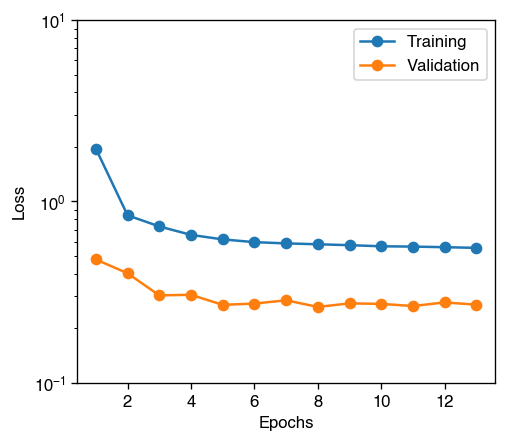

In [ ]:
# Plot training/validation losses
f, ax = pyplot.subplots(1, 1, figsize=(4.5, 4))
n_epochs_actual = len(training_history.history['loss'])

ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    training_history.history['loss'],
    marker='o',
    label='Training',
)
ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    training_history.history['val_loss'],
    marker='o',
    label='Validation',
)
ax.set_yscale('log')
ax.set_ylim(0.1, 10)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

# Evaluate model

In [ ]:
# Load model
model = tensorflow.keras.models.load_model(
    'model_optimus5p_multioutput.h5',
)

In [ ]:
# Make predictions on test set
data_test_pred = model.predict(data_test_x)
# data_test_pred_full = model_to_fit.predict([data_test_x, data_test_y, len(data_test_w)*data_test_w])

In [ ]:
# Show performance
dataset_idx = 0
for cell_line_idx, (cell_line, cell_line_reps) in enumerate(zip(cell_lines, cell_lines_reps)):
    for cell_line_rep in range(cell_line_reps):
        print(f"For cell line {cell_line}, replicate {cell_line_rep + 1}/{cell_line_reps}:")

        dataset_sample_idx = numpy.nonzero(data_test_w[:, dataset_idx] > 0)[0]
        dataset_test_y = data_test_y[dataset_sample_idx, dataset_idx]
        dataset_test_w = data_test_w[dataset_sample_idx, dataset_idx]
        dataset_test_pred = data_test_pred[dataset_sample_idx, cell_line_idx]
        # dataset_test_pred = data_test_pred_full[dataset_sample_idx, dataset_idx]

        # Calculate overall R^2
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataset_test_y, dataset_test_pred)
        print("R = {:.4f}".format(r_value))
        print("R^2 = {:.4f}".format(r_value**2))

        # Calculate MSE
        mse = numpy.mean((dataset_test_y - dataset_test_pred)**2)
        print('MSE = {:.4f}'.format(mse))

        # Calculate weighted MSE
        mse = numpy.sum(((dataset_test_y - dataset_test_pred)**2)*dataset_test_w)
        print('Weighted MSE = {:.4f}'.format(mse))
        
        dataset_idx += 1
        print()

For cell line HEK293T, replicate 1/2:
R = 0.9595
R^2 = 0.9206
MSE = 0.2251
Weighted MSE = 0.0969

For cell line HEK293T, replicate 2/2:
R = 0.9317
R^2 = 0.8680
MSE = 0.8595
Weighted MSE = 0.0928

For cell line T cells, replicate 1/2:
R = 0.9096
R^2 = 0.8274
MSE = 0.2830
Weighted MSE = 0.0425

For cell line T cells, replicate 2/2:
R = 0.9123
R^2 = 0.8323
MSE = 1.0024
Weighted MSE = 0.1588

For cell line HepG2, replicate 1/1:
R = 0.9117
R^2 = 0.8311
MSE = 0.2085
Weighted MSE = 0.0311



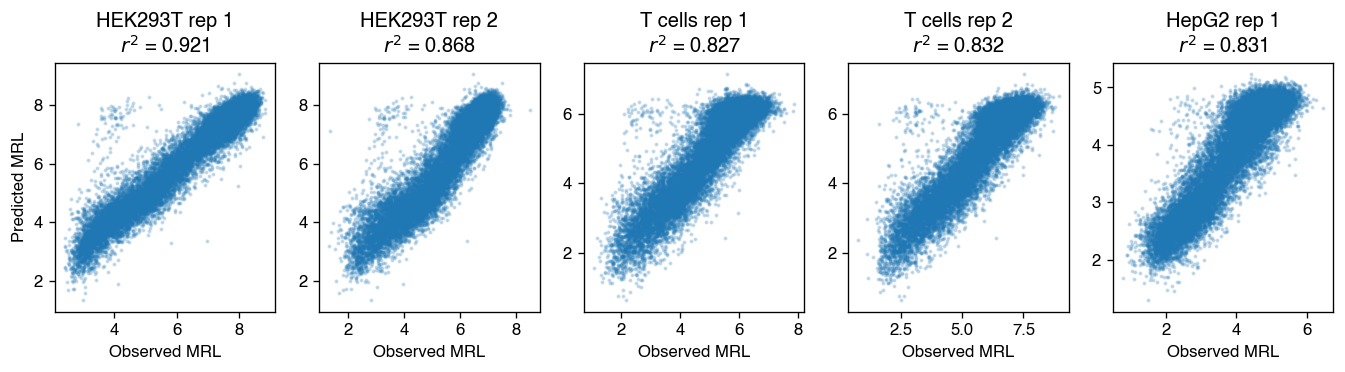

In [ ]:
# Scatter plots for all datasets
n_datasets = numpy.sum(cell_lines_reps)
fig, axes = pyplot.subplots(1, n_datasets, figsize=(2.75*n_datasets, 2.75))

dataset_idx = 0
for cell_line_idx, (cell_line, cell_line_reps) in enumerate(zip(cell_lines, cell_lines_reps)):
    for cell_line_rep in range(cell_line_reps):
        
        ax = axes[dataset_idx]
        
        # Extract relevant data
        dataset_sample_idx = numpy.nonzero(data_test_w[:, dataset_idx] > 0)[0]
        dataset_test_y = data_test_y[dataset_sample_idx, dataset_idx]
        dataset_test_w = data_test_w[dataset_sample_idx, dataset_idx]
        dataset_test_pred = data_test_pred[dataset_sample_idx, cell_line_idx]
        # dataset_test_pred = data_test_pred_full[dataset_sample_idx, dataset_idx]

        # Calculate r value
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataset_test_y, dataset_test_pred)

        # Plot
        ax.scatter(dataset_test_y, dataset_test_pred, s=2, alpha=.2, rasterized=True)
        ax.set_title(f"{cell_line} rep {cell_line_rep + 1}\n$r^2$ = {r_value**2:.3f}")
        ax.set_xlabel('Observed MRL')
        if dataset_idx == 0:
            ax.set_ylabel('Predicted MRL')

        dataset_idx += 1

fig.savefig(f'mrl_vs_predictions_multiout_scatter.svg', dpi=300, bbox_inches='tight')
fig.savefig(f'mrl_vs_predictions_multiout_scatter.png', dpi=300, bbox_inches='tight')

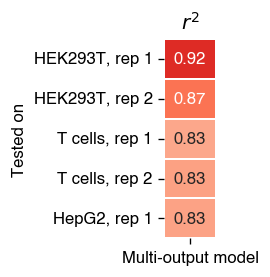

In [ ]:
dataset_idx = 0
r2_values = []
labels = []
cell_lines_hm = ['HEK293T', 'T cells', 'HepG2']
cell_lines_reps_hm = [2, 2, 1]
for cell_line_idx, (cell_line, cell_line_reps) in enumerate(zip(cell_lines_hm, cell_lines_reps_hm)):
    for cell_line_rep in range(cell_line_reps):
        
        ax = axes[dataset_idx]
        
        # Extract relevant data
        dataset_sample_idx = numpy.nonzero(data_test_w[:, dataset_idx] > 0)[0]
        dataset_test_y = data_test_y[dataset_sample_idx, dataset_idx]
        dataset_test_w = data_test_w[dataset_sample_idx, dataset_idx]
        dataset_test_pred = data_test_pred[dataset_sample_idx, cell_line_idx]
        # dataset_test_pred = data_test_pred_full[dataset_sample_idx, dataset_idx]

        # Calculate r value
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dataset_test_y, dataset_test_pred)

        # Store r^2 value
        r2_values.append(r_value**2)
        labels.append(f"{cell_line}, rep {cell_line_rep + 1}")

        dataset_idx += 1

# Make dataframe with axis labels
xlabels = ['Multi-output model']
ylabels = labels
r2_df = pandas.DataFrame(r2_values, index=ylabels, columns=xlabels)

# Plot heatmap
fig, ax = pyplot.subplots(figsize=(2.75/5, 2.2))
seaborn.heatmap(
    r2_df,
    annot=True,
    fmt='0.2f',
    vmin=0.75,
    vmax=1,
    ax=ax,
    cbar=False,
    # cbar_kws={'label': '$r^2$', 'aspect': 15},
    # edgecolors='k',
    linewidths=1,
    cmap='Reds',
)
# ax.set_xlabel('Trained on')
ax.set_ylabel('Tested on')
ax.set_title('$r^2$')

fig.savefig(f'mrl_vs_predictions_multiout_r2_heatmap.svg', dpi=300, bbox_inches='tight')
fig.savefig(f'mrl_vs_predictions_multiout_r2_heatmap.png', dpi=300, bbox_inches='tight')